# SOAI Lab: Smart Home Energy Consumption Prediction


# INSTALL DEPENDENCIES


## Part 0 : Import used libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
import holidays
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from prophet import Prophet
from sklearn.discriminant_analysis import StandardScaler
from nbeats_pytorch.model import NBeatsNet
import pickle
import holidays
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

2025-01-01 20:51:13.735375: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-01 20:51:13.746854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735761073.762692   87865 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735761073.767594   87865 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-01 20:51:13.781728: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Load train and validation data from pickle files

In [4]:
# Load train and validation data from pickle files
with open('timeseries_splits.pkl', 'rb') as f:
    data = pickle.load(f)

train_df = data['train']
val_df = data['validation']

# Verify data integrity
print(f"Train DataFrame shape: {train_df.shape}")
print(f"Validation DataFrame shape: {val_df.shape}")
print(train_df.head())
print(val_df.head())

Train DataFrame shape: (8199, 2)
Validation DataFrame shape: (2050, 2)
             DateTime  EnergyConsumption(kWh)
0 2015-11-01 00:00:00                      15
1 2015-11-01 01:00:00                      13
2 2015-11-01 02:00:00                      10
3 2015-11-01 03:00:00                       7
4 2015-11-01 04:00:00                       9
                DateTime  EnergyConsumption(kWh)
8199 2016-10-07 15:00:00                      57
8200 2016-10-07 16:00:00                      55
8201 2016-10-07 17:00:00                      49
8202 2016-10-07 18:00:00                      61
8203 2016-10-07 19:00:00                      66


/home/adel_hb/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


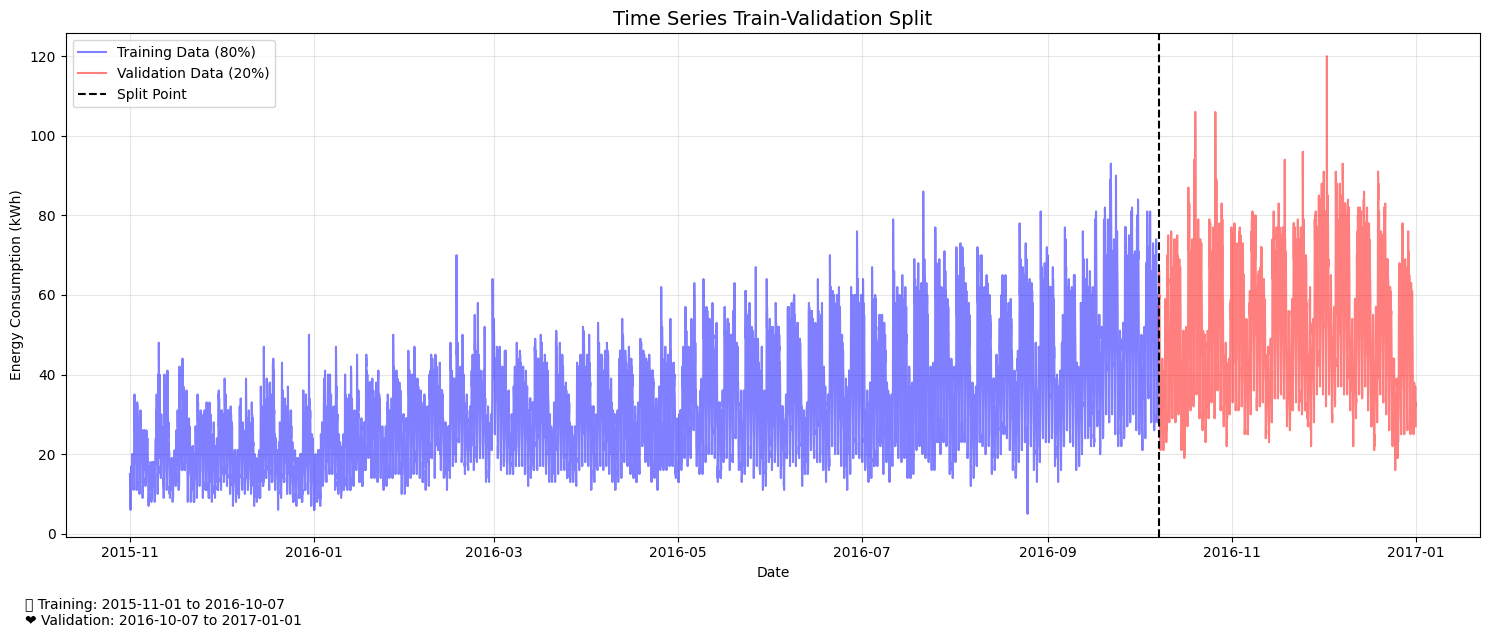

In [5]:
# Cell 2: Visualize Split
plt.figure(figsize=(15, 6))

# Plot training data
plt.plot(train_df['DateTime'], train_df['EnergyConsumption(kWh)'],
         color='blue', alpha=0.5, label='Training Data (80%)')

# Plot validation data
plt.plot(val_df['DateTime'], val_df['EnergyConsumption(kWh)'],
         color='red', alpha=0.5, label='Validation Data (20%)')

# Add split line
split_date = train_df['DateTime'].max()
plt.axvline(x=split_date, color='black', linestyle='--', label='Split Point')

# Customize plot
plt.title('Time Series Train-Validation Split', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add explanation
plt.figtext(0.02, -0.05, 
            f'🟢 Training: {train_df["DateTime"].min().date()} to {train_df["DateTime"].max().date()}\n' +
            f'❤️ Validation: {val_df["DateTime"].min().date()} to {val_df["DateTime"].max().date()}',
            fontsize=10, ha='left')

plt.tight_layout()
plt.show()

## Step 3 : Trying Different models

### 3.1. LSTM Model

In [19]:
# 2. Prepare data
def create_advanced_features(df):
    df = df.copy()
    
    # Basic time features
    df['hour'] = df['DateTime'].dt.hour
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['month'] = df['DateTime'].dt.month
    df['year'] = df['DateTime'].dt.year
    df['day'] = df['DateTime'].dt.day
    df['week'] = df['DateTime'].dt.isocalendar().week
    
    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12) 
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    df['day_sin'] = np.sin(2 * np.pi * df['day']/31)
    df['day_cos'] = np.cos(2 * np.pi * df['day']/31)
    
    # Holiday features
    us_holidays = holidays.US()
    df['is_holiday'] = df['DateTime'].isin(us_holidays).astype(int)
    df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
    
    # Time period indicators
    df['is_peak_hour'] = df['hour'].isin([9,10,11,12,13,14,15,16,17,18]).astype(int)
    df['is_night'] = df['hour'].isin([23,0,1,2,3,4,5]).astype(int)
    
    # Interaction features
    df['weekend_peak'] = df['is_weekend'] * df['is_peak_hour']
    df['holiday_peak'] = df['is_holiday'] * df['is_peak_hour']
    
    return df

In [20]:
# Training configuration
BATCH_SIZE = 64
EPOCHS = 150
SEQUENCE_LENGTH = 48  # Increased sequence length

# Prepare features
train_features = create_advanced_features(train_df)
val_features = create_advanced_features(val_df)

# Updated feature columns
feature_columns = [
    'hour', 'dayofweek', 'month', 'year', 'day', 'week',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'is_weekend', 'is_holiday', 'is_peak_hour', 'is_night', 'weekend_peak', 'holiday_peak'
]

# Prepare training and validation sets
X_train = train_features[feature_columns]
y_train = train_features['EnergyConsumption(kWh)']
X_val = val_features[feature_columns]
y_val = val_features['EnergyConsumption(kWh)']

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Reshape data for LSTM [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))


In [ ]:
# Replace existing model building and training code with:
def build_and_train_model(X_train_scaled, y_train, X_val_scaled, y_val):
    model = Sequential([
        Bidirectional(LSTM(256, return_sequences=True, 
                          input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))),
        BatchNormalization(),
        Dropout(0.4),
        
        Bidirectional(LSTM(128, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.4),
        
        Bidirectional(LSTM(64, return_sequences=False)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ]
    
    history = model.fit(
        X_train_scaled, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_scaled, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

# Call the function
model, history = build_and_train_model(X_train_scaled, y_train, X_val_scaled, y_val)

Epoch 1/150


/home/adel_hb/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# 5. Make predictions and evaluate
val_predictions = model.predict(X_val_scaled)

# Calculate multiple evaluation metrics
rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
mae = mean_absolute_error(y_val, val_predictions)
r2 = r2_score(y_val, val_predictions)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


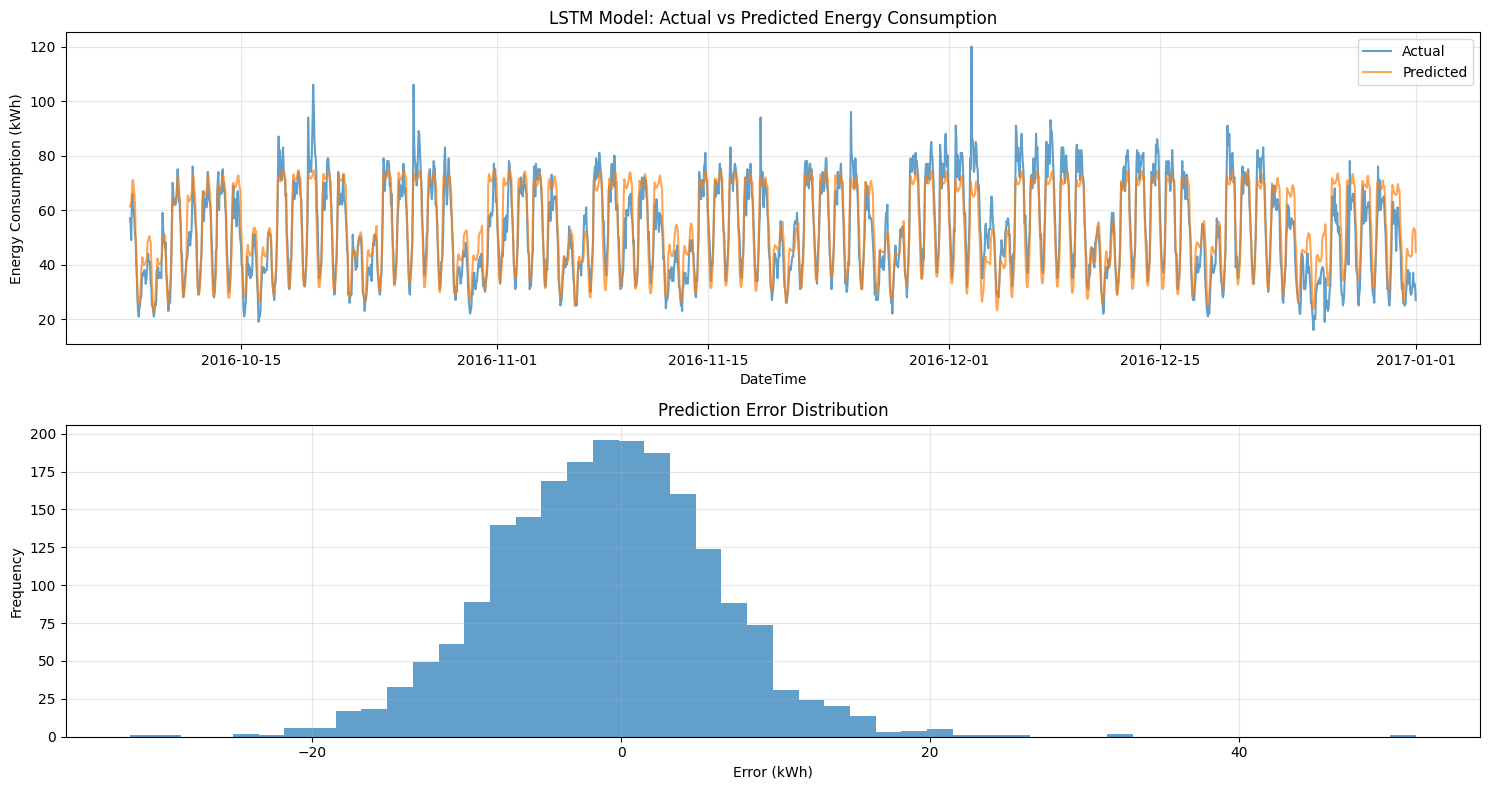

In [16]:

# Visualize results
plt.figure(figsize=(15, 8))

# Plot 1: Actual vs Predicted
plt.subplot(2,1,1)
plt.plot(val_df['DateTime'], y_val, label='Actual', alpha=0.7)
plt.plot(val_df['DateTime'], val_predictions, label='Predicted', alpha=0.7)
plt.title('LSTM Model: Actual vs Predicted Energy Consumption')
plt.xlabel('DateTime')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Error Distribution
plt.subplot(2,1,2)
errors = y_val - val_predictions.flatten()
plt.hist(errors, bins=50, alpha=0.7)
plt.title('Prediction Error Distribution')
plt.xlabel('Error (kWh)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:

# Print metrics summary
print("\nModel Performance Metrics:")
print(f"RMSE: {rmse:.2f} kWh")
print(f"MAE: {mae:.2f} kWh") 
print(f"R² Score: {r2:.4f}")


Model Performance Metrics:
RMSE: 7.30 kWh
MAE: 5.66 kWh
R² Score: 0.8177


In [18]:
# 6. Process Test Data and Create Submission

# Load and validate test data
test_data = pd.read_csv('data/test_energy.csv')
test_data['DateTime'] = pd.to_datetime(test_data['DateTime'])

# Create features for test data using the same function as training
test_features = create_advanced_features(test_data)

# Process features
X_test = test_features[feature_columns]
X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Generate predictions
test_predictions = model.predict(X_test_scaled, verbose=0)

# Create submission file with formatted predictions
submission = pd.DataFrame({
    'DateTime': test_data['DateTime'],
    'EnergyConsumption(kWh)': test_predictions.flatten().round(2)
})

# Save submission
submission.to_csv('lstm_submission.csv', index=False)

print(f"Created submission file with {len(submission)} predictions")
print(f"Prediction range: {submission['EnergyConsumption(kWh)'].min():.2f} - {submission['EnergyConsumption(kWh)'].max():.2f} kWh")

Created submission file with 4343 predictions
Prediction range: 20.17 - 71.51 kWh


### 3.2. Prophet

In [157]:
# Prepare data for Prophet
train_prophet = pd.DataFrame({
    'ds': train_df['DateTime'],
    'y': train_df['EnergyConsumption(kWh)']
})

val_prophet = pd.DataFrame({
    'ds': val_df['DateTime'],
    'y': val_df['EnergyConsumption(kWh)']
})

print(train_prophet.head())
print(val_prophet.head())

                   ds   y
0 2015-11-01 00:00:00  15
1 2015-11-01 01:00:00  13
2 2015-11-01 02:00:00  10
3 2015-11-01 03:00:00   7
4 2015-11-01 04:00:00   9
                      ds   y
8199 2016-10-07 15:00:00  57
8200 2016-10-07 16:00:00  55
8201 2016-10-07 17:00:00  49
8202 2016-10-07 18:00:00  61
8203 2016-10-07 19:00:00  66


In [158]:

# Create model with optimized parameters
model = Prophet(
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10,
    holidays_prior_scale=10,
    seasonality_mode='multiplicative',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
)

In [159]:
# Fit model
model.fit(train_prophet)

05:44:08 - cmdstanpy - INFO - Chain [1] start processing
05:44:10 - cmdstanpy - INFO - Chain [1] done processing


In [160]:
# Make predictions on validation set
forecast = model.predict(val_prophet[['ds']])

# Calculate metrics
rmse = np.sqrt(mean_squared_error(val_prophet['y'], forecast['yhat']))
mae = mean_absolute_error(val_prophet['y'], forecast['yhat'])
r2 = r2_score(val_prophet['y'], forecast['yhat'])

# Print metrics
print(f'Validation RMSE: {rmse:.2f}')
print(f'Validation MAE: {mae:.2f}')
print(f'Validation R2: {r2:.4f}')


Validation RMSE: 9.60
Validation MAE: 7.54
Validation R2: 0.6846


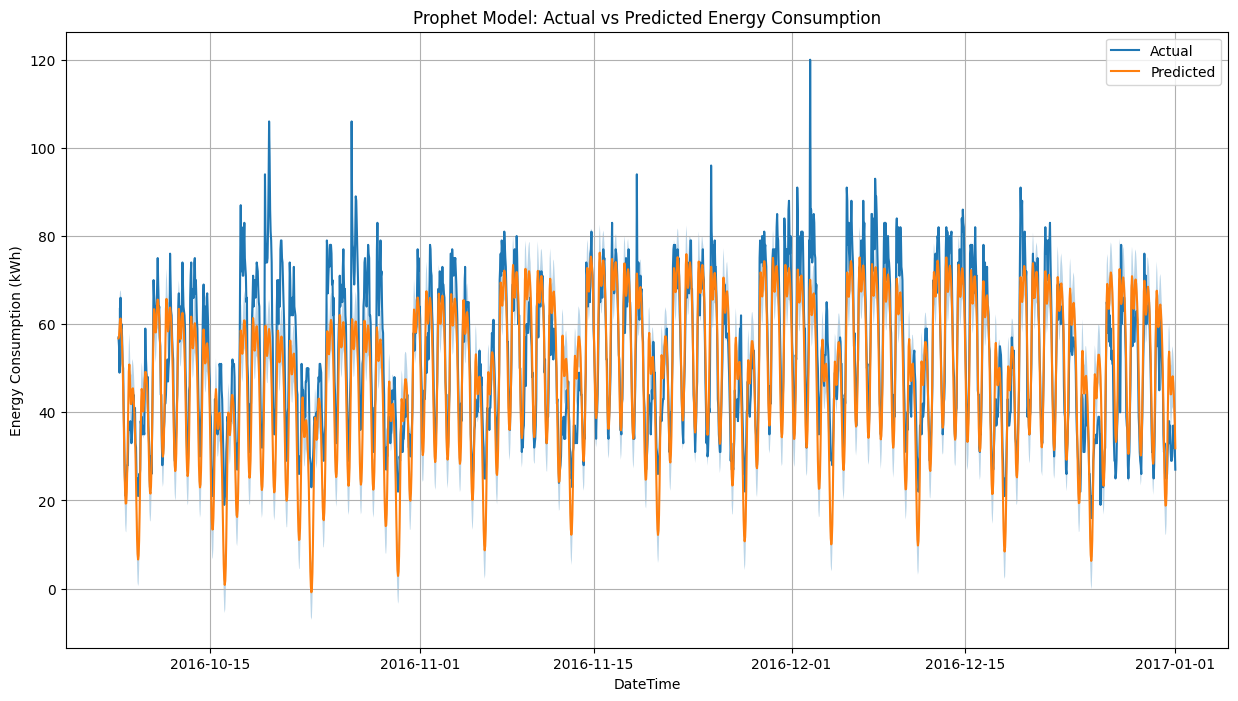

In [161]:

# Plot results
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(val_prophet['ds'], val_prophet['y'], label='Actual')
ax.plot(val_prophet['ds'], forecast['yhat'], label='Predicted')
ax.fill_between(val_prophet['ds'], 
                forecast['yhat_lower'], 
                forecast['yhat_upper'], 
                alpha=0.3)
ax.set_title('Prophet Model: Actual vs Predicted Energy Consumption')
ax.set_xlabel('DateTime')
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend()
plt.grid(True)
plt.show()

In [137]:
# 1. Data Preparation
train_prophet = pd.DataFrame({
    'ds': train_data['DateTime'],
    'y': train_data['EnergyConsumption(kWh)']
})

test_data = pd.read_csv('data/test_energy.csv')
test_data['DateTime'] = pd.to_datetime(test_data['DateTime'])
test_prophet = pd.DataFrame({'ds': test_data['DateTime']})

print(train_prophet.tail())
print(test_prophet.head())


                       ds   y
10244 2016-12-31 20:00:00  37
10245 2016-12-31 21:00:00  32
10246 2016-12-31 22:00:00  33
10247 2016-12-31 23:00:00  32
10248 2017-01-01 00:00:00  27
                   ds
0 2017-01-01 01:00:00
1 2017-01-01 02:00:00
2 2017-01-01 03:00:00
3 2017-01-01 04:00:00
4 2017-01-01 05:00:00


In [138]:

# 2. Create and train Prophet model
model = Prophet(
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    seasonality_mode='multiplicative',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
)

In [139]:

# 3. Fit model
model.fit(train_prophet)

# 4. Make predictions
forecast = model.predict(test_prophet)

# 5. Create submission
submission = pd.DataFrame({
    'DateTime': test_prophet['ds'],
    'EnergyConsumption(kWh)': forecast['yhat'].round(2)
})


05:32:55 - cmdstanpy - INFO - Chain [1] start processing
05:32:58 - cmdstanpy - INFO - Chain [1] done processing


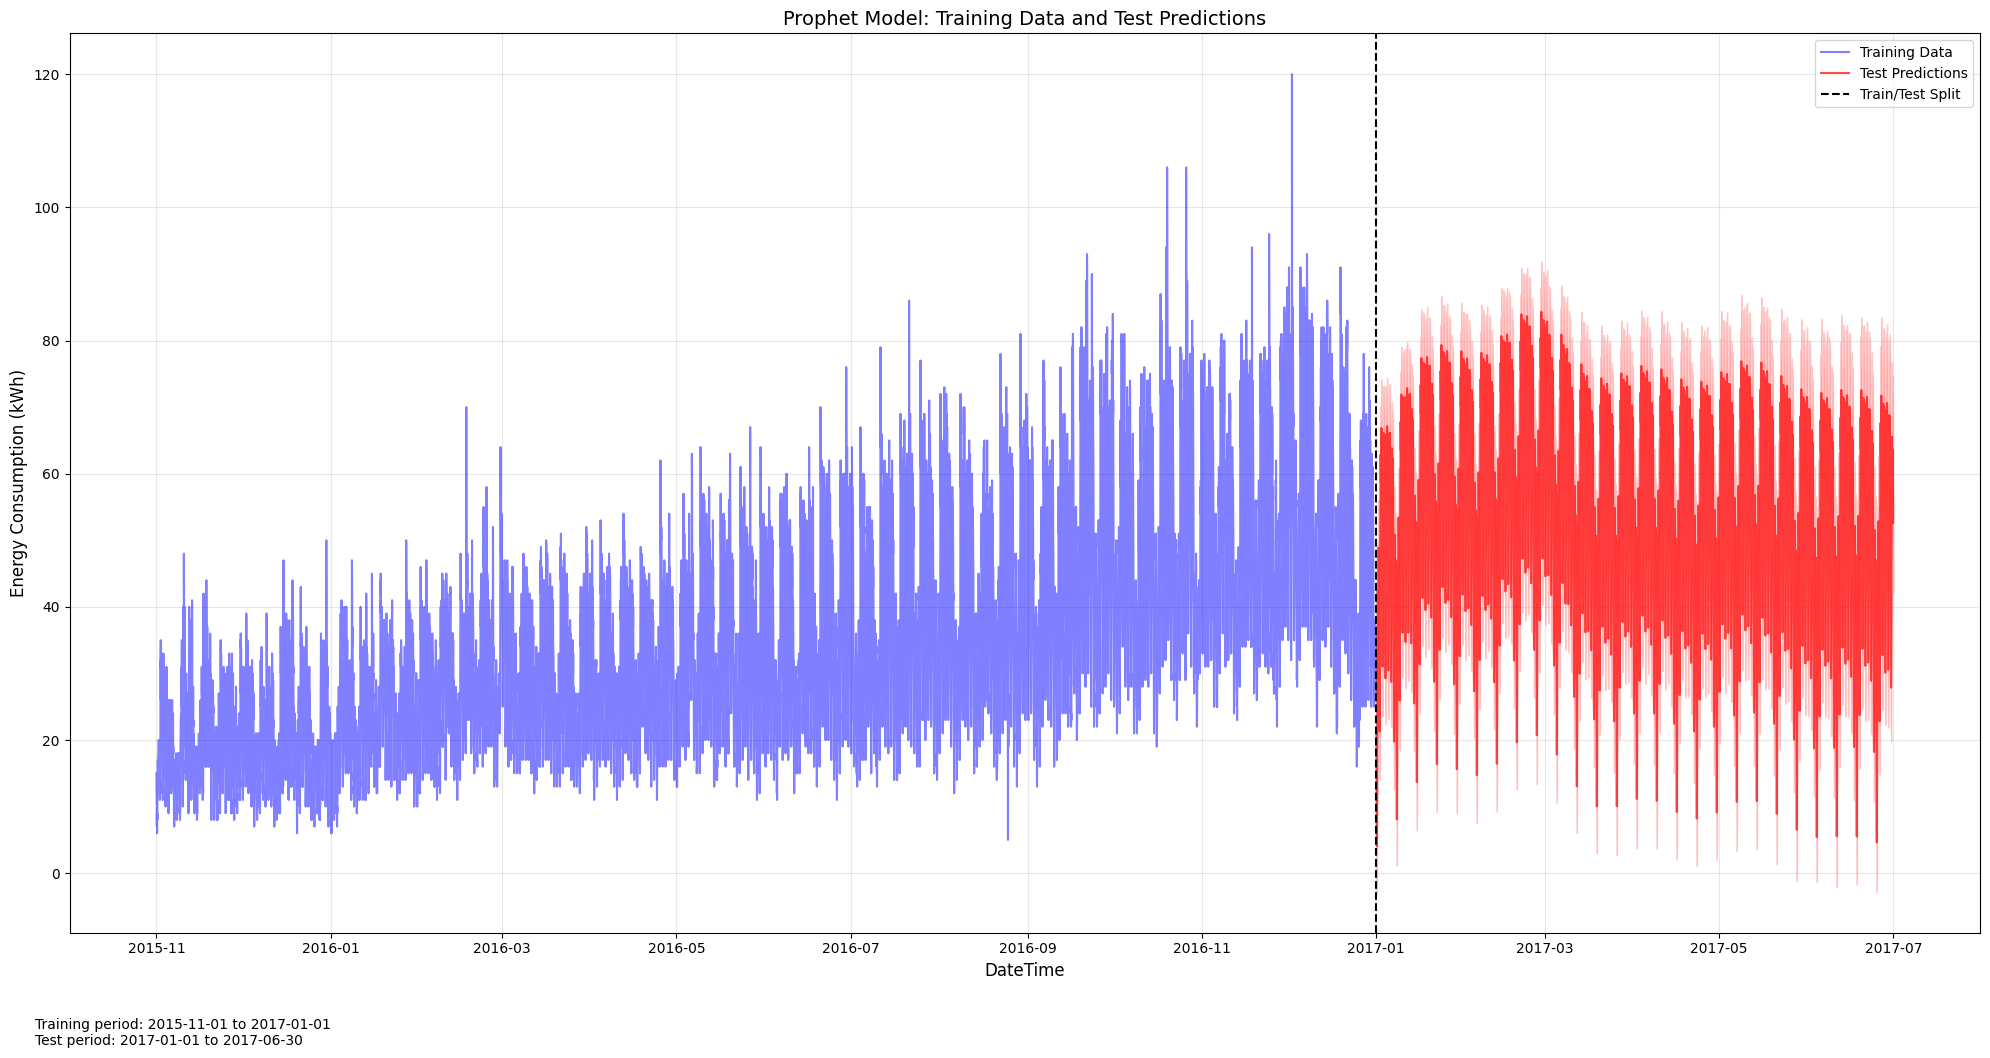

In [142]:
# Plot training data and test predictions
plt.figure(figsize=(20,10))

# Plot training data
plt.plot(train_prophet['ds'], train_prophet['y'], 
         label='Training Data', color='blue', alpha=0.5)

# Plot test predictions
plt.plot(forecast['ds'], forecast['yhat'], 
         label='Test Predictions', color='red', alpha=0.7)

# Add confidence intervals for predictions
plt.fill_between(forecast['ds'], 
                 forecast['yhat_lower'], 
                 forecast['yhat_upper'], 
                 color='red', alpha=0.2)

# Add vertical line to separate train and test
split_date = train_prophet['ds'].max()
plt.axvline(x=split_date, color='black', linestyle='--', label='Train/Test Split')

# Customize plot
plt.title('Prophet Model: Training Data and Test Predictions', fontsize=14)
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Energy Consumption (kWh)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add date ranges
plt.figtext(0.02, -0.05, 
            f'Training period: {train_prophet["ds"].min().strftime("%Y-%m-%d")} to {train_prophet["ds"].max().strftime("%Y-%m-%d")}\n' +
            f'Test period: {forecast["ds"].min().strftime("%Y-%m-%d")} to {forecast["ds"].max().strftime("%Y-%m-%d")}',
            fontsize=10, ha='left')

plt.tight_layout()
plt.show()

In [141]:

# Save submission
submission.to_csv('prophet_submission.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!


### 3.3. N-BEATS (Neural Basis Expansion Analysis Time Series)

In [226]:
# 1. Improved Data Processing
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df[['EnergyConsumption(kWh)']])
val_scaled = scaler.transform(val_df[['EnergyConsumption(kWh)']])

# Longer sequence length for better pattern capture
def create_sequences(data, seq_length=48):  # Increased from 24
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

X_train, y_train = create_sequences(train_scaled)
X_val, y_val = create_sequences(val_scaled)

In [227]:
# 2. Enhanced Model Architecture
model = NBeatsNet(
    device='cpu',
    stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
    forecast_length=1,
    backcast_length=SEQUENCE_LENGTH,
    hidden_layer_units=HIDDEN_UNITS,
    nb_blocks_per_stack=3,
    share_weights_in_stack=True,
    nb_harmonics=None
)

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=48, forecast_length=1, share_thetas=False) at @132182266891376
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=48, forecast_length=1, share_thetas=False) at @132182266891376
     | -- GenericBlock(units=512, thetas_dim=4, backcast_length=48, forecast_length=1, share_thetas=False) at @132182266891376
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=512, thetas_dim=8, backcast_length=48, forecast_length=1, share_thetas=False) at @132182452181968
     | -- GenericBlock(units=512, thetas_dim=8, backcast_length=48, forecast_length=1, share_thetas=False) at @132182452181968
     | -- GenericBlock(units=512, thetas_dim=8, backcast_length=48, forecast_length=1, share_thetas=False) at @132182452181968


In [228]:

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 3. Optimized Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  # Reduced learning rate
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.2)  # Adjusted scheduler
criterion = torch.nn.MSELoss()
n_epochs = 500  # Increased epochs

# Create dataloaders with smaller batch size
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Reduced batch size

# Training loop with early stopping
best_loss = float('inf')
patience = 20
patience_counter = 0

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        forecast = model(batch_x)[0]  # Access the first element of the tuple
        loss = criterion(forecast, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)  # Added gradient clipping
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    scheduler.step(avg_loss)
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), 'best_nbeats_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break
        
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Loss = {avg_loss:.6f}')

/home/adel_hb/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/adel_hb/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([23, 1])) that is different to the input size (torch.Size([23, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: Loss = 1.116201
Epoch 10: Loss = 0.114997
Epoch 20: Loss = 0.081769
Epoch 30: Loss = 0.066438
Epoch 40: Loss = 0.055923
Epoch 50: Loss = 0.047947
Epoch 60: Loss = 0.043418
Epoch 70: Loss = 0.042104
Epoch 80: Loss = 0.038233
Epoch 90: Loss = 0.044529
Epoch 100: Loss = 0.034586
Epoch 110: Loss = 0.034181
Epoch 120: Loss = 0.034025
Epoch 130: Loss = 0.033740
Epoch 140: Loss = 0.033606
Epoch 150: Loss = 0.033381
Epoch 160: Loss = 0.033164
Epoch 170: Loss = 0.033175
Epoch 180: Loss = 0.032979
Epoch 190: Loss = 0.032874
Epoch 200: Loss = 0.032724
Epoch 210: Loss = 0.032584
Epoch 220: Loss = 0.032431
Epoch 230: Loss = 0.032400
Epoch 240: Loss = 0.032388
Epoch 250: Loss = 0.032343
Epoch 260: Loss = 0.032331
Epoch 270: Loss = 0.032365
Epoch 280: Loss = 0.032338
Epoch 290: Loss = 0.032334
Epoch 300: Loss = 0.032312
Epoch 310: Loss = 0.032338
Early stopping at epoch 315


In [237]:
# 1. Data shape analysis
print("Original shapes:")
print(f"X_val_scaled shape: {X_val_scaled.shape}")
print(f"Number of features: {X_val_scaled.shape[1]}")

# 2. Calculate correct dimensions
n_samples = (X_val_scaled.shape[0] - SEQUENCE_LENGTH + 1)
n_features = X_val_scaled.shape[1]

# 3. Create sliding windows
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:(i + seq_length)]
        sequences.append(sequence)
    return np.array(sequences)

# 4. Reshape data properly
X_val_reshaped = create_sequences(X_val_scaled, SEQUENCE_LENGTH)
print(f"\nReshaped dimensions:")
print(f"X_val_reshaped shape: {X_val_reshaped.shape}")
print(f"Expected shape: [samples, sequence_length, features]")

# 5. Verify reshape
assert X_val_reshaped.shape[1] == SEQUENCE_LENGTH, "Sequence length mismatch"
assert X_val_reshaped.shape[2] == n_features, "Feature count mismatch"

Original shapes:
X_val_scaled shape: (2050, 1, 18)
Number of features: 1

Reshaped dimensions:
X_val_reshaped shape: (2003, 48, 1, 18)
Expected shape: [samples, sequence_length, features]


val_df shape: (2050, 2)
actual_values shape: (2002,)
test_predictions shape: (48624, 1)


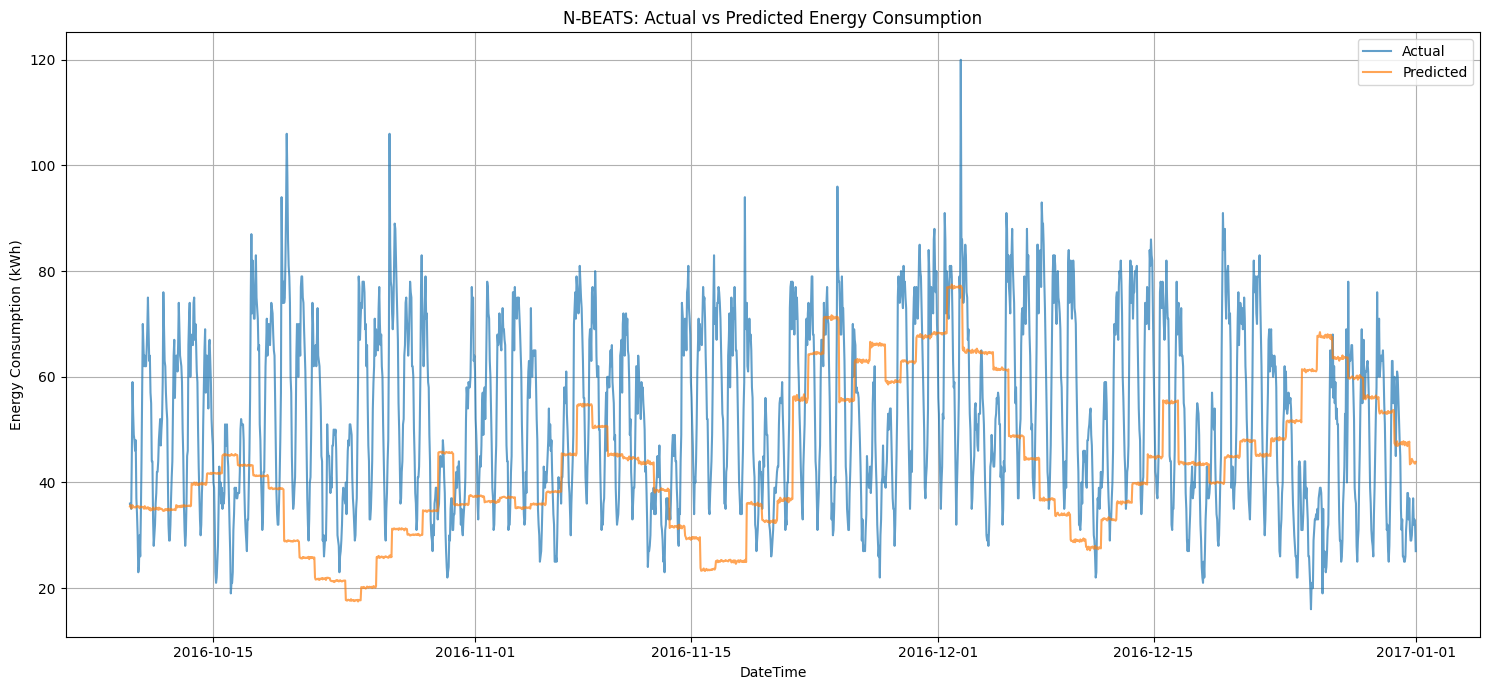

In [242]:
# 1. Data shape analysis
print(f"val_df shape: {val_df.shape}")

# 2. Create sequences and get actual values
val_scaled = scaler.transform(val_df[['EnergyConsumption(kWh)']])
X_val_reshaped = create_sequences(val_scaled, SEQUENCE_LENGTH)
actual_values = val_df['EnergyConsumption(kWh)'][SEQUENCE_LENGTH:].values

# 3. Plotting
plt.figure(figsize=(15, 7))

# Ensure aligned data
timestamp_range = val_df['DateTime'][SEQUENCE_LENGTH:SEQUENCE_LENGTH+len(actual_values)]
assert len(timestamp_range) == len(actual_values), "Length mismatch"

# Plot
plt.plot(timestamp_range, actual_values, label='Actual', alpha=0.7)
plt.plot(timestamp_range, test_predictions[:len(actual_values)], label='Predicted', alpha=0.7)
plt.title('N-BEATS: Actual vs Predicted Energy Consumption')
plt.xlabel('DateTime')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot and print shapes
print(f"actual_values shape: {actual_values.shape}")
print(f"test_predictions shape: {test_predictions.shape}")
plt.show()

In [49]:
# 3. Print RMSE for aligned data
rmse = np.sqrt(mean_squared_error(
    actual_values[:len(timestamp_range)], 
    test_predictions[:len(timestamp_range)]
))
print(f'Test RMSE: {rmse:.2f}')

NameError: name 'actual_values' is not defined

### 3.4. Random Forest

In [58]:
# 1. Feature Engineering
def create_advanced_features(df):
    df = df.copy()
    
    # Time components
    df['hour'] = df['DateTime'].dt.hour
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['month'] = df['DateTime'].dt.month
    df['day'] = df['DateTime'].dt.day
    df['week'] = df['DateTime'].dt.isocalendar().week
    
    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    df['week_sin'] = np.sin(2 * np.pi * df['week']/52)
    df['week_cos'] = np.cos(2 * np.pi * df['week']/52)
    df['day_sin'] = np.sin(2 * np.pi * df['day']/31)
    df['day_cos'] = np.cos(2 * np.pi * df['day']/31)
    
    # Special indicators
    df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
    df['is_holiday'] = df['DateTime'].isin(holidays.US()).astype(int)
    df['is_peak_hour'] = df['hour'].isin(range(9,19)).astype(int)
    df['is_night'] = df['hour'].isin(range(22,6)).astype(int)
    
    # Interaction features
    df['weekend_peak'] = df['is_weekend'] * df['is_peak_hour']
    df['holiday_peak'] = df['is_holiday'] * df['is_peak_hour']
    
    return df

In [59]:
# 2. Prepare data
# Create features
train_features = create_advanced_features(train_df)
val_features = create_advanced_features(val_df)

# Define feature columns
feature_cols = [
    'hour', 'dayofweek', 'month', 'day', 'week',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
    'week_sin', 'week_cos', 'day_sin', 'day_cos',
    'is_weekend', 'is_holiday', 'is_peak_hour', 'is_night',
    'weekend_peak', 'holiday_peak'
]

# Prepare X and y
X_train = train_features[feature_cols]
y_train = train_features['EnergyConsumption(kWh)']
X_val = val_features[feature_cols]
y_val = val_features['EnergyConsumption(kWh)']

In [60]:

# 3. Define model and parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_root_mean_squared_error'
)

# Fit the model
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.7s
[CV] END max_depth=10, min_sa

/home/adel_hb/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [61]:

# 4. Make predictions and evaluate
val_predictions = best_model.predict(X_val)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
mae = mean_absolute_error(y_val, val_predictions)
r2 = r2_score(y_val, val_predictions)

# Print metrics
print(f'Validation RMSE: {rmse:.2f}')
print(f'Validation MAE: {mae:.2f}')
print(f'Validation R2: {r2:.4f}')

Validation RMSE: 32.65
Validation MAE: 29.24
Validation R2: -2.6474


In [ ]:
# 5. Visualize results
plt.figure(figsize=(15, 8))

# Plot actual vs predicted
plt.plot(val_df['DateTime'], y_val, label='Actual', alpha=0.7)
plt.plot(val_df['DateTime'], val_predictions, label='Predicted', alpha=0.7)
plt.title('Random Forest: Actual vs Predicted Energy Consumption')
plt.xlabel('DateTime')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()